In [23]:
if (!require(survRM2)) install.packages('survRM2') # nolint
library('survRM2') # nolint
if (!require(mvtnorm)) install.packages('mvtnorm') # nolint
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach')
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot') # nolint
library('IRdisplay')

n_cores <- detectCores()
n_cores
cluster <- makeCluster(16) 
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster,
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Function.R')
clusterExport(cluster, "expo_gen_2stages")

[1] 128

# Experiments

## Stage I ( Proportional Hazard Assumption)
#### According to Jung (2017) double arms 2 stages log rank test (page 642)   
####  $H_0 : \lambda_0 = \lambda_1 = 1.609$    
####  $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   

Then we calculate the empirical RMST of $E$, $C$ under $H_1$ to decide the searching region of $m_1, t_1$ and estimate τ  
Here I used mean($Sur_C$) + 3 * std($Sur_C$) as estimated τ.

In [36]:
set.seed(2024)
emp_result <- emp_est(acc_time = 1.67,cen_time = 1, lambda_H0 = 1.609, lambda_H1 = 0.916)
emp_c <- emp_result[1]
emp_e <- emp_result[2]
emp_tau <-  emp_result[3]

cat(emp_c,emp_e,emp_tau)

0.5978719 0.9118425 1.97215

------

## 1. One sided(greater) Log rank test VS Simple RMST

### 1.1 (Jung 2017 page5 example 1)
#### It is annouced that 2 sample one-sided log rank test with N = 51 per arm 
#### The power can reach 0.9 when α = 0.1. 
#### Simple RMST: Reject $H_0$ when $RMST_E - RMST_C> m_1$


 The simulated alpha of one-sided log rank test is: 0.0999 
The simulated alpha of one-sided Simple RMST test is: 0.1053 
************* The empirical alpha is closed to nominated alpha 0.1 ************* 
The simulated power of one-sided log rank test is: 0.9098 
The simulated power of simple rmst test is: 0.912

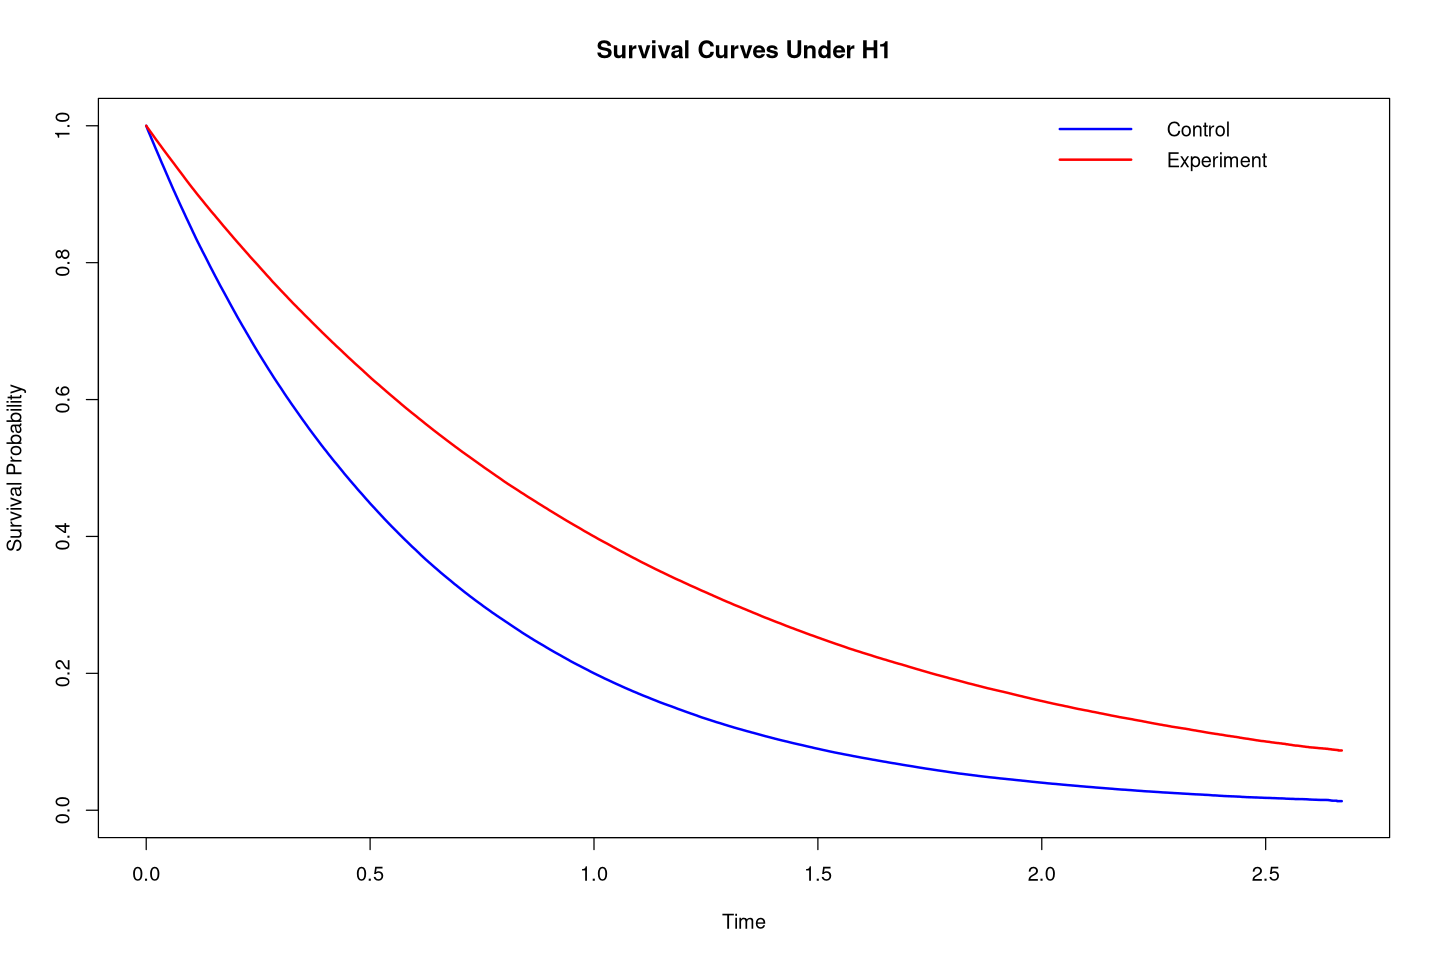

In [33]:
set.seed(2024)
sim_size = 10000
n = 51
acc_time <- 1.67
cen_time <- 1

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
# survival curve
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H0
log_rank_a <- log_rank_sim(data_C = data_C, data_E = data_E_H0, sim_size = sim_size,
                            n = n,alpha = 0.1 ,sided = 'greater')
simple_rmst_a <- RMST_sim_test(data_C = data_C, data_E = data_E_H0, sim_size = sim_size, tau = 2,
                            n = n,alpha = 0.1 ,sided = 'greater')
cat(' The simulated alpha of one-sided log rank test is:', log_rank_a$rejection, '\n')
cat('The simulated alpha of one-sided Simple RMST test is:',simple_rmst_a$test_result$rejection,'\n')
cat('************* The empirical alpha is closed to nominated alpha 0.1 *************','\n')
log_rank_b <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.1 ,sided = 'greater')
simple_rmst_b <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = 2,
                            n = n, alpha = 0.1 ,sided = 'greater')
cat( 'The simulated power of one-sided log rank test is:', log_rank_b$rejection,'\n')
cat('The simulated power of simple rmst test is:', simple_rmst_b$test_result$rejection)

The logrank.test function should be reliable.

### 1.2 Eaton (2020) P288 Table1 (two-sided) Scenario 1

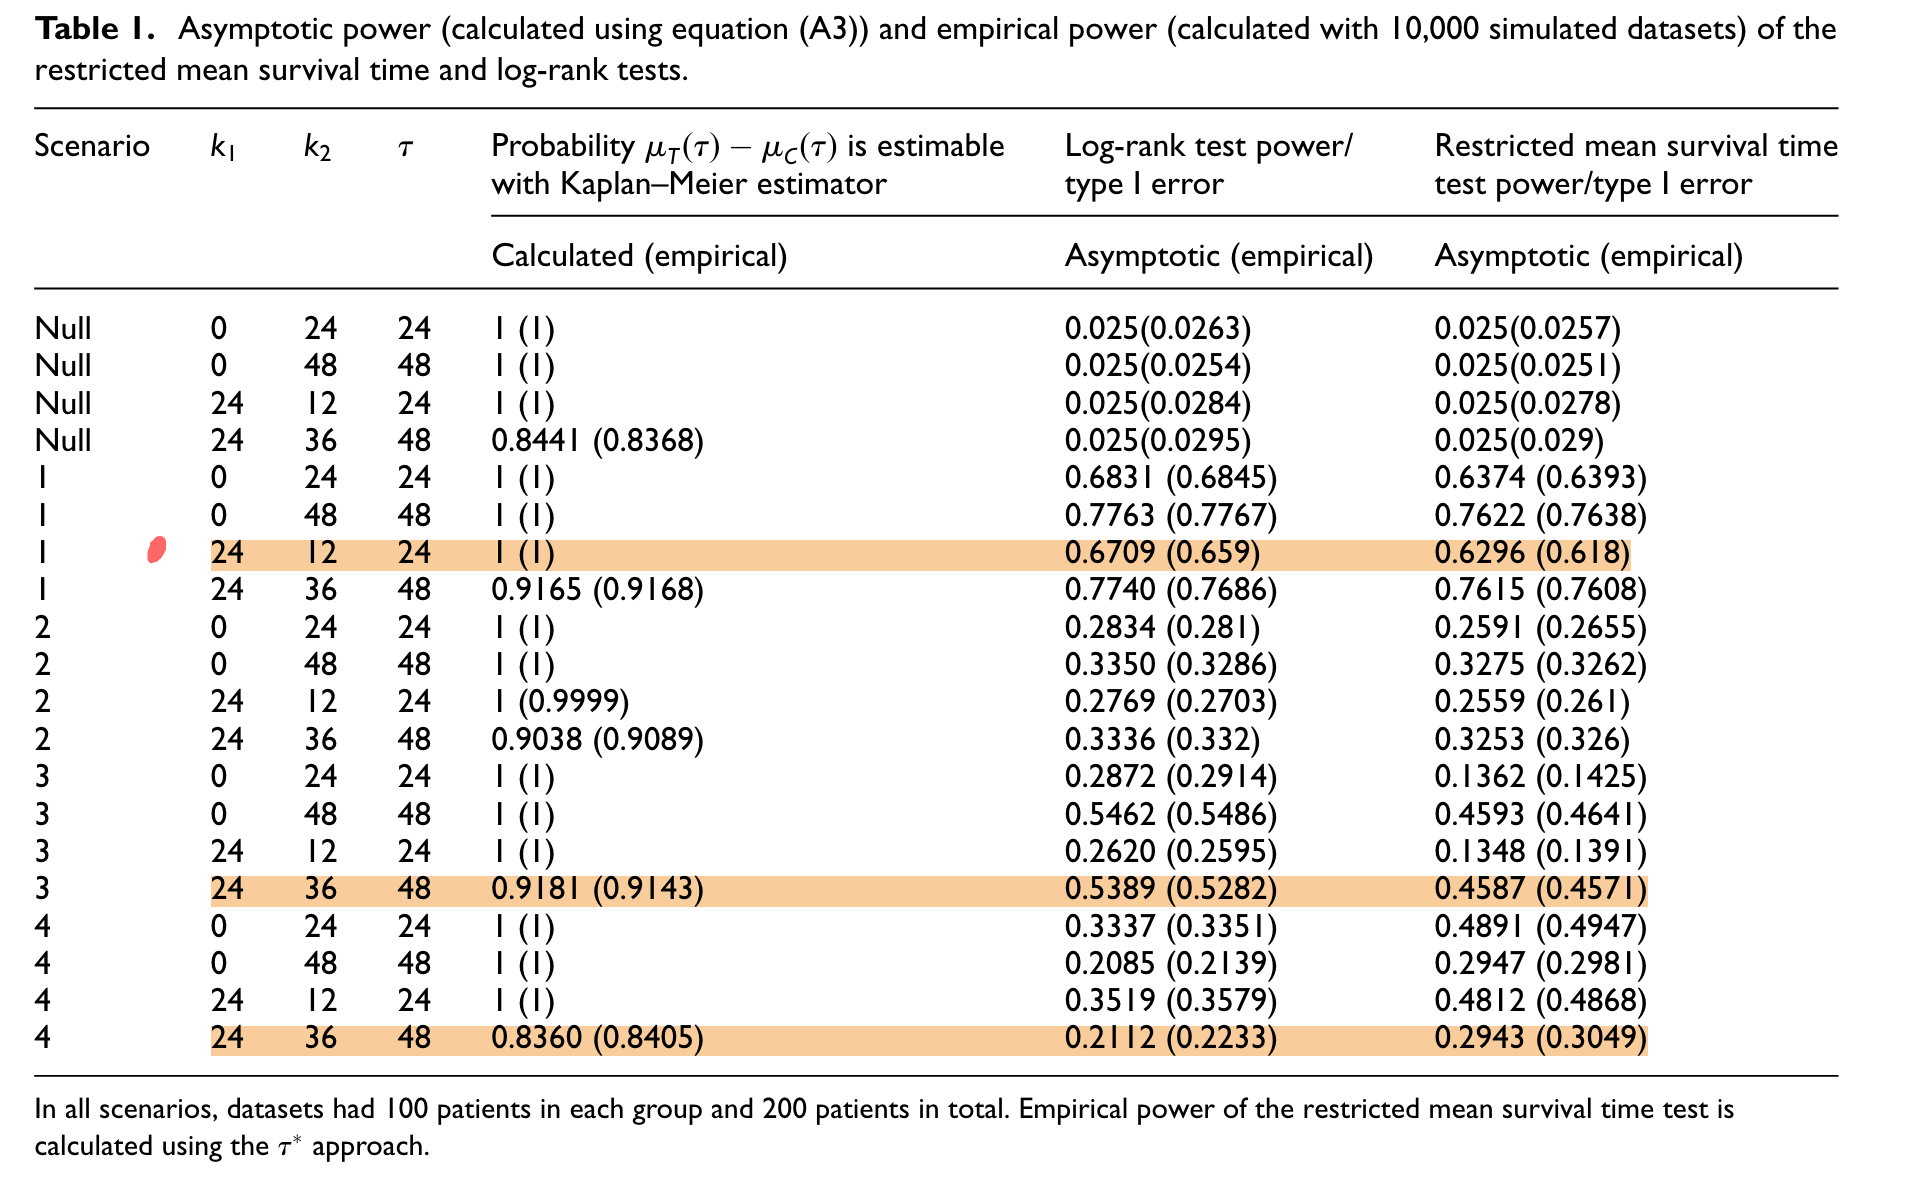

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.6659 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.6229 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.7735 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.7392

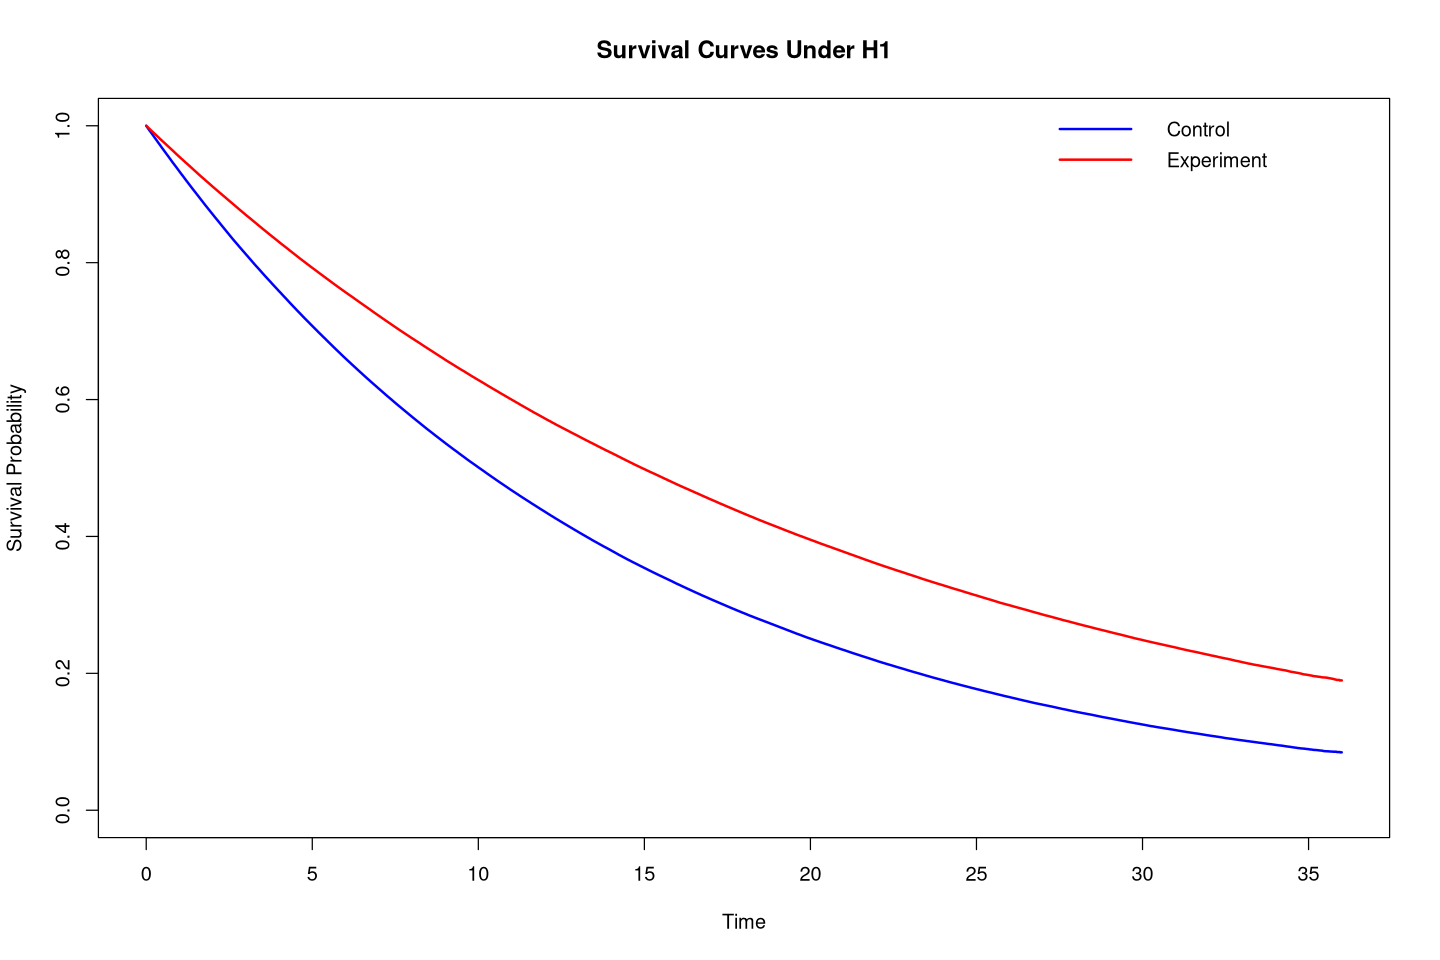

In [37]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
lambda_H1 <- lambda_H0 * 0.67
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 24
n <- 100  
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
    
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
display_jpeg(file='figures/Eaton_2020_table1.JPEG')
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)

### <span style="color:yellow">2.  Compare the power of our rejection method with one-sided log rank 
(Use the setting in Eaton 2020 scenario I above)
#### Reject H0 when:
#### $ \textcolor{lightgreen}{E(\tau)-C(\tau)>m_1\ \&\  E(\tau)>t_1}$ , where E and C are RMST value of two groups

In [38]:
rmst_h0 <- RMST_sim_cal(n = n,data_E = data_E_H0, data_C = data_C,tau = tau, sim_size = sim_size)
rmst_h1 <- RMST_sim_cal(n = n,data_E = data_E_H1, data_C = data_C,tau = tau, sim_size = sim_size) 
rmst_h0 # RMST value of two groups under H0
rmst_h1

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
Est.,11.78608,11.98625,10.35872,8.885448,11.28230,11.54357,12.63470,12.32156,12.24995,11.26232,⋯,12.61427,12.22324,12.21238,9.27519,10.03633,13.01092,12.74883,11.49188,11.81280,11.39645
Est.,12.11271,11.00432,11.97168,13.037975,12.30073,11.78262,11.45341,11.81419,11.43327,13.58951,⋯,12.97409,11.24479,12.20065,10.41401,11.76327,12.33152,12.69658,12.94205,10.18923,10.67274


,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
Est.,11.78608,11.98625,10.35872,8.885448,11.28230,11.54357,12.63470,12.32156,12.24995,11.26232,⋯,12.61427,12.22324,12.21238,9.27519,10.03633,13.01092,12.74883,11.49188,11.81280,11.39645
Est.,13.91461,13.47423,13.34215,14.790352,14.22461,14.61269,14.65909,15.18430,14.75135,14.17257,⋯,14.82888,16.24144,12.57647,13.76587,15.09190,15.37814,13.21817,16.82339,14.04088,13.67531


In [52]:
opt_alpha <- 1
opt_power <- 0
opt_m1 <- 0
opt_t1 <- 0
opt_mt <- c()
 for (m1 in seq(from = -2, to = 2, by = 0.01))
        { # step = 1/100
     for (t1 in seq(from = 8, to = 14, by = 0.05)) # search 100 times in the interval
         {
            proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
            proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))
            if (proc_h0/sim_size > 0 & proc_h0/sim_size < 0.05 & 
                proc_h1/sim_size >= opt_power) # return the best 
            {
                opt_alpha <- proc_h0 / sim_size
                opt_power <- proc_h1 / sim_size
                opt_m1 <- m1
                opt_t1 <- t1
                opt_mt <- c(opt_m1, opt_t1, opt_alpha, opt_power)
             }
         }
        }

opt_mt <- data.frame(opt_mt)
rownames(opt_mt) <- c('m1','t1','alpha','power')
opt_mt

,opt_mt
,<dbl>
m1,-1.0300
t1,13.1000
alpha,0.0456
power,0.9436


#### WHY SO POWERFUL????

### Simple RMST grid search

In [54]:
opt_alpha <- 1
opt_power <- 0
opt_m1 <- 0
opt_t1 <- 0
opt_mt <- c()
 for (m1 in seq(from = -3, to = 3, by = 0.005))
    { # step = 1/100
        proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1))
        proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1))
        if (proc_h0/sim_size > 0 & proc_h0/sim_size < 0.05 & 
            proc_h1/sim_size >= opt_power) # return the best 
        {
            opt_alpha <- proc_h0 / sim_size
            opt_power <- proc_h1 / sim_size
            opt_m1 <- m1
            opt_t1 <- t1
            opt_mt <- c(opt_m1, opt_t1, opt_alpha, opt_power)
       }
    }

opt_mt <- data.frame(opt_mt)
rownames(opt_mt) <- c('m1','t1','alpha','power')
opt_mt

,opt_mt
,<dbl>
m1,1.9050
t1,14.0000
alpha,0.0499
power,0.7636


#### The power is closed to the test result (0.7392)

-------

# Discussion ( One stage)

### 1. The relationship between power and sample size under this hypothesis.

#### Find the most powerful m1,t1 pairs under each n1. Larger sample size should lead to a larger $\beta$


In [4]:
sim_size <- 10000  #simulate 10000 pairs of (E,C) under H0 and H1 respectively
acc_time <- 1.67
cen_time <- 1
tau <- 2
set.seed(2024)

result_alln1 <- foreach(n1 = 35:55, .combine = 'cbind',.packages = 'foreach') %dopar% {  
    #n1 here is the sample size per arm
    data_C <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 1)[ , c(4,5,1)]    
    data_E_H0 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 1)[ , c(4,5,1)]
    data_E_H1 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 1)[ , c(4,5,1)]    
    rmst_h0 <- RMST_sim_cal(n = n1,data_E = data_E_H0, data_C = data_C,tau = 2,sim_size = sim_size)
    rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E_H1, data_C = data_C,tau = 2,sim_size = sim_size)
    opt_alpha <- 1
    opt_power <- 0
    opt_m1 <- 0
    opt_t1 <- 0
    opt_mt <- c()
     for (m1 in seq(from = -1, to = 1, by = 1/100))
         { # step = 1/100
         for (t1 in seq(from = 0, to = 1.5, by = 1/100)) # search 100 times in the interval
             {
                proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
                proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))
                if (proc_h0/sim_size > 0 & proc_h0/sim_size < 0.1 & 
                    proc_h1/sim_size >= opt_power) # return the best 
                {
                    opt_alpha <- proc_h0 / sim_size
                    opt_power <- proc_h1 / sim_size
                    opt_m1 <- m1
                    opt_t1 <- t1
                    opt_mt <- c(n1, opt_m1, opt_t1, opt_alpha, opt_power)
                }
              }
        }
    opt_mt
}


In [5]:
#load('/mnt/diff_n1_power.RData')  # The result of last loop is already saved
result_alln1 <- data.frame(result_alln1)
rownames(result_alln1) <- c('n1','m1','t1','alpha','power')
save(result_alln1, file = '/home/r27user6/RMST_Code/diff_n1_power.RData')
result_alln1

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.12,result.13,result.14,result.15,result.16,result.17,result.18,result.19,result.20,result.21
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
n1,35.0000,36.0000,37.0000,38.0000,39.0000,40.0000,41.0000,42.0000,43.0000,44.0000,⋯,46.0000,47.0000,48.0000,49.0000,50.0000,51.0000,52.0000,53.0000,54.0000,55.0000
m1,0.0100,-0.0400,-0.1400,-0.0100,0.0000,-0.1500,-0.1300,-0.0900,-0.1700,-0.0800,⋯,-0.1200,-0.1000,-0.1500,0.0100,-0.1200,-0.0900,-0.0700,-0.1700,-0.0700,-0.1600
t1,0.7100,0.7100,0.7200,0.7100,0.7100,0.7100,0.7100,0.7100,0.7100,0.7100,⋯,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000
alpha,0.0999,0.0992,0.0891,0.0995,0.0990,0.0899,0.0944,0.0899,0.0901,0.0884,⋯,0.0939,0.0969,0.0965,0.0992,0.0980,0.0913,0.0895,0.0899,0.0888,0.0874
power,0.9484,0.9535,0.9525,0.9624,0.9609,0.9699,0.9724,0.9699,0.9743,0.9743,⋯,0.9811,0.9846,0.9839,0.9846,0.9859,0.9861,0.9880,0.9887,0.9898,0.9892


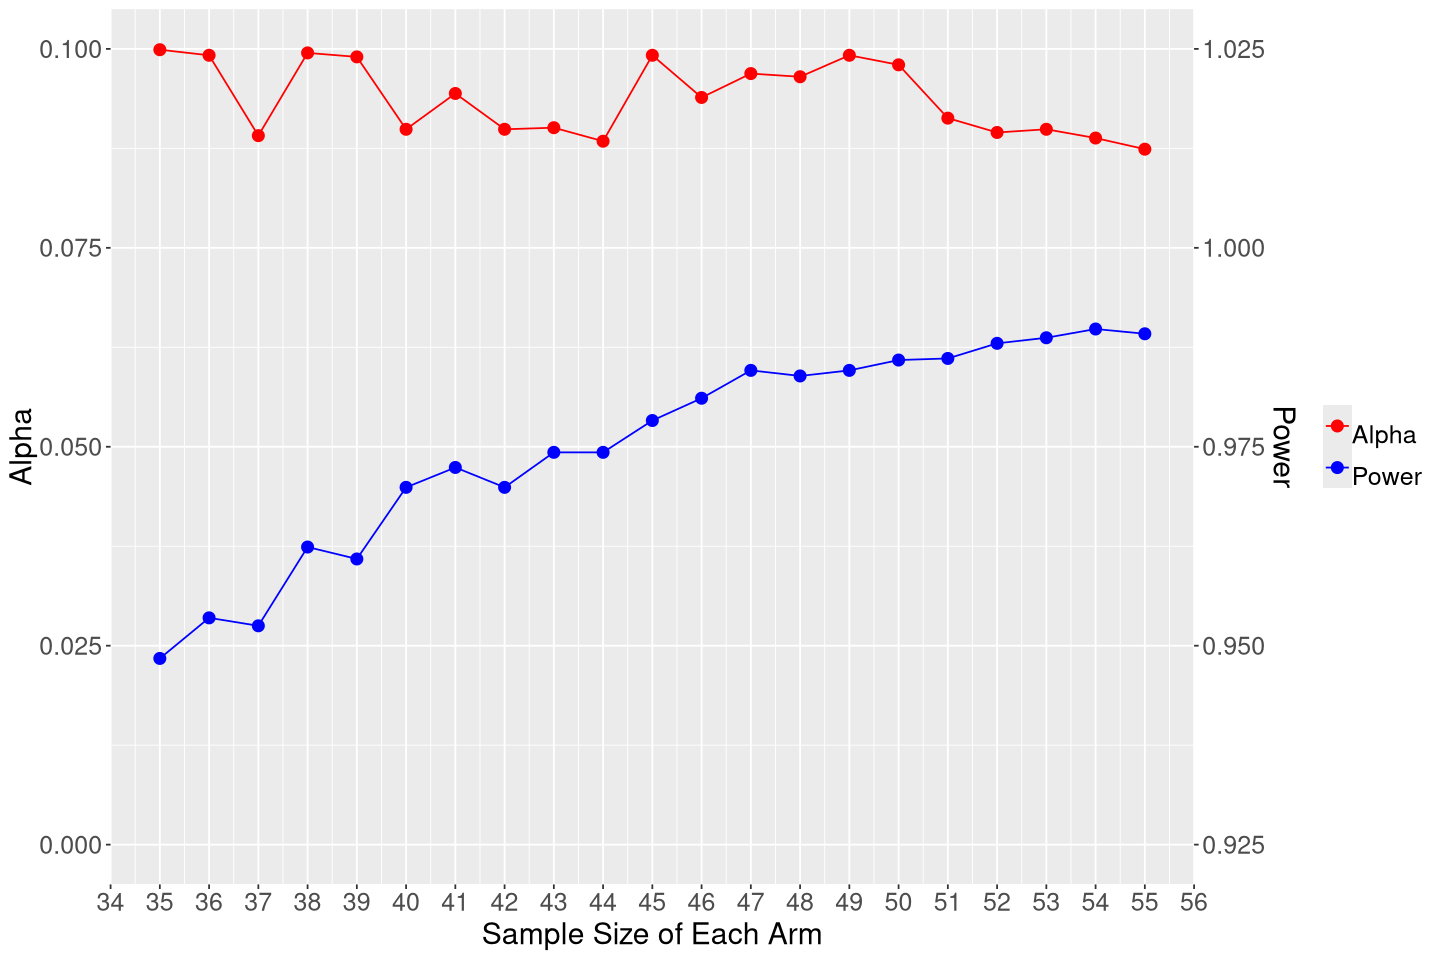

In [7]:
df <- as.data.frame(t(result_alln1[c(1,4,5),]))
options(repr.plot.width = 12, repr.plot.height = 8)

plot_n1 <- ggplot(df) +
  geom_point(data = df, aes(x = n1, y = alpha, color = "Alpha"),size = 3) +
  geom_point(data = df, aes(x = n1, y = (power - 0.925) , color = "Power"),size = 3) +
  geom_line(data = df, aes(x = n1, y = alpha, color = "Alpha")) +
  geom_line(data = df, aes(x = n1, y = (power - 0.925), color = "Power")) +
  scale_x_continuous(breaks = 33:58 ) +
  scale_y_continuous(limits = c(0, 0.1),
                     sec.axis = sec_axis(transform = ~ . + 0.925, name = "Power")) +
  scale_color_manual(values = c("Alpha" = "red", "Power" = "blue"),
                     labels = c("Alpha", "Power"))+
  theme(legend.title = element_blank(),
        axis.title = element_text(size = 18, margin = margin(t = 20)),
        axis.text = element_text(size = 15,margin = margin(t = 10)),
        legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "Sample Size of Each Arm", y = "Alpha")

plot_n1

## 2. The relationship between power and $\tau$ under this hypothesis.
### $H_0 : \lambda_0 = \lambda_1 = 1.609$    
### $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  
### Under H1, the mean value of Survival time in 2 groups (10000 samples) are shown below.
### The Empirical $\tau$ is calculated by $Surtime_{E} + 3 * Std (Surtime_E)$

In [30]:
set.seed(2024)
sim_size <- 10000  #simulate 10000 pairs of (E,C) under H0 and H1 respectively
acc_time <- 1.67
cen_time <- 1
n1 <- 51
data_C <- expo_gen(N = n1*sim_size, acc_time = acc_time, lambda = 1.609, cen_time = cen_time,arm = 0)
data_E_H0 <- expo_gen(N = n1*sim_size, acc_time = acc_time, lambda = 1.609, cen_time = cen_time,arm = 1)
data_E_H1 <- expo_gen(N = n1*sim_size, acc_time = acc_time, lambda = 0.916, cen_time = cen_time,arm = 1)
cat(mean(data_C[,1]),mean(data_E_H0[,1]),mean(data_E_H1[,1]),emp_tau)

0.5784267 0.5787006 0.8680528 1.97215

### From the result in result_alln1 we can see that the sample size did not greatly affect the critical value $m_1,\ t_1$
### So we set $n_1 = 51,\ m_1 = 0,\ t_1 = 0.73 $ and calculate $\alpha$ and power under different $\tau$
### Here we need new function to collect the times of $\tau$ adjustment in or RMST estimation.
(Since if the preset $\tau$ is larger than $max(RMST_E)$, it will be adjusted to $max(RMST_E)$)

In [32]:
set.seed(2024)

start_time <- Sys.time()

result_alltau <- foreach(i = 1:20, .combine = 'cbind',.packages = 'foreach') %dopar% {  #n1 here is the sample size per arm
    
    tau <- 0.6 + (i-1) * 0.1 
    c0 <- 0
    c1 <- 1
    rmst_h0 <- RMST_sim_test(n = n1, data_E = data_E_H0, data_C = data_C, 
                            tau = tau, sim_size = sim_size)
    rmst_h1 <- RMST_sim_test(n = n1, data_E = data_E_H1, data_C = data_C, 
                            tau = tau, sim_size = sim_size)
    for (k in 1:sim_size)
                    {
                      if (rmst_h0[2,k] - rmst_h0[1,k] > 0 & rmst_h0[2,k] > 0.73)
                      {c0 = c0 + 1}
                      else if (rmst_h1[2,k] - rmst_h1[1,k] > 0 & rmst_h1[2,k] > 0.73)
                      {c1 = c1 + 1}
                    }
    c(tau, c0/sim_size, c1/sim_size, rmst_h0[3,sim_size]/sim_size, rmst_h1[3,sim_size]/sim_size) # proportion of adjusted tau
}

end_time <- Sys.time()
cat(end_time - start_time)

1.119018

In [33]:
#load('/mnt/diff_tau_power.RData')  # The result of last loop is already saved
result_alltau <- data.frame(result_alltau)
rownames(result_alltau) <- c('tau','alpha','power','adj_tau_H0','adj_tau_H1')
save(result_alltau, file = '/home/r27user6/RMST_Code/diff_tau_power.RData')
result_alltau

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,result.11,result.12,result.13,result.14,result.15,result.16,result.17,result.18,result.19,result.20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tau,6e-01,7e-01,8e-01,0.9000,1.0000,1.1000,1.2000,1.3000,1.4000,1.5000,1.6000,1.7000,1.8000,1.9000,2.0000,2.1000,2.2000,2.3000,2.4000,2.5000
alpha,0e+00,0e+00,0e+00,0.0000,0.0000,0.0001,0.0002,0.0011,0.0036,0.0079,0.0158,0.0249,0.0322,0.0402,0.0473,0.0510,0.0537,0.0552,0.0556,0.0560
power,1e-04,1e-04,1e-04,0.0046,0.0649,0.2531,0.4891,0.6757,0.7966,0.8710,0.9051,0.9216,0.9277,0.9279,0.9253,0.9230,0.9213,0.9205,0.9203,0.9201
adj_tau_H0,0e+00,0e+00,0e+00,0.0001,0.0001,0.0005,0.0021,0.0081,0.0329,0.0761,0.1554,0.2669,0.4049,0.5477,0.6801,0.7954,0.8844,0.9408,0.9755,0.9923
adj_tau_H1,0e+00,0e+00,0e+00,0.0001,0.0001,0.0004,0.0014,0.0045,0.0171,0.0393,0.0812,0.1456,0.2321,0.3381,0.4567,0.5852,0.7019,0.8143,0.9033,0.9634


### How alpha and beta change across different $\tau$

In [34]:
df <- as.data.frame(t(result_alltau[c(1,2,3),]))
plot_tau_ab <- ggplot(df) +
  geom_point(aes(x = df$tau, y = df$alpha, color = "Alpha"),size = 3) +
  geom_point(aes(x = df$tau, y = df$power * 0.05  , color = "Power"),size = 3) +
  geom_line(aes(x = df$tau, y = df$alpha, color = "Alpha")) +
  geom_line(aes(x = df$tau, y = df$power * 0.05, color = "Power")) +
  scale_x_continuous(name = "tau", breaks = df$tau) +
  scale_y_continuous(limits = c(0, 0.05),
                     sec.axis = sec_axis(trans = ~ . * 20, name = "Power")) +
  scale_color_manual(values = c("Alpha" = "red", "Power" = "blue"),
                     labels = c("Alpha", "Power"))+
  theme(legend.title = element_blank(),
        axis.title = element_text(size = 18, margin = margin(t = 20)),
        axis.text.x = element_text(angle = 30,size = 15,margin = margin(t = 10)),
        axis.text.y = element_text(size = 15,margin = margin(t = 10)),
        legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "tau", y = "Alpha")

df_2 <- as.data.frame(t(result_alltau[c(1,4,5),]))
plot_tau_adj <- ggplot(df) +
  geom_point(aes(x = df_2$tau, y = df_2$adj_tau_H0, color = "adj_tau_H0"),size = 3) +
  geom_point(aes(x = df_2$tau, y = df_2$adj_tau_H1  , color = "adj_tau_H1"),size = 3) +
  geom_line(aes(x = df_2$tau, y = df_2$adj_tau_H0, color = "adj_tau_H0")) +
  geom_line(aes(x = df_2$tau, y = df_2$adj_tau_H1 , color = "adj_tau_H1")) +
  scale_x_continuous(name = "tau", breaks = df_2$tau) +
  scale_y_continuous(limits = c(0, 1)) +
  scale_color_manual(values = c("adj_tau_H0" = "red", "adj_tau_H1" = "blue"),
                     labels = c("adj_tau_H0", "adj_tau_H1"))+
  theme(legend.title = element_blank(),
        axis.title = element_text(size = 18, margin = margin(t = 20)),
        axis.text.x = element_text(angle = 30,size = 15,margin = margin(t = 10)),
        axis.text.y = element_text(size = 15,margin = margin(t = 10)),
        legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "tau", y = "Proportional of Adjusted tau Among 10000 Simulation")

Warning message:
“Use of `df$tau` is discouraged.
ℹ Use `tau` instead.”
Warning message:
“Use of `df$alpha` is discouraged.
ℹ Use `alpha` instead.”
Warning message:
“Use of `df$tau` is discouraged.
ℹ Use `tau` instead.”
Warning message:
“Use of `df$power` is discouraged.
ℹ Use `power` instead.”
Warning message:
“Use of `df$tau` is discouraged.
ℹ Use `tau` instead.”
Warning message:
“Use of `df$alpha` is discouraged.
ℹ Use `alpha` instead.”
Warning message:
“Use of `df$tau` is discouraged.
ℹ Use `tau` instead.”
Warning message:
“Use of `df$power` is discouraged.
ℹ Use `power` instead.”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”


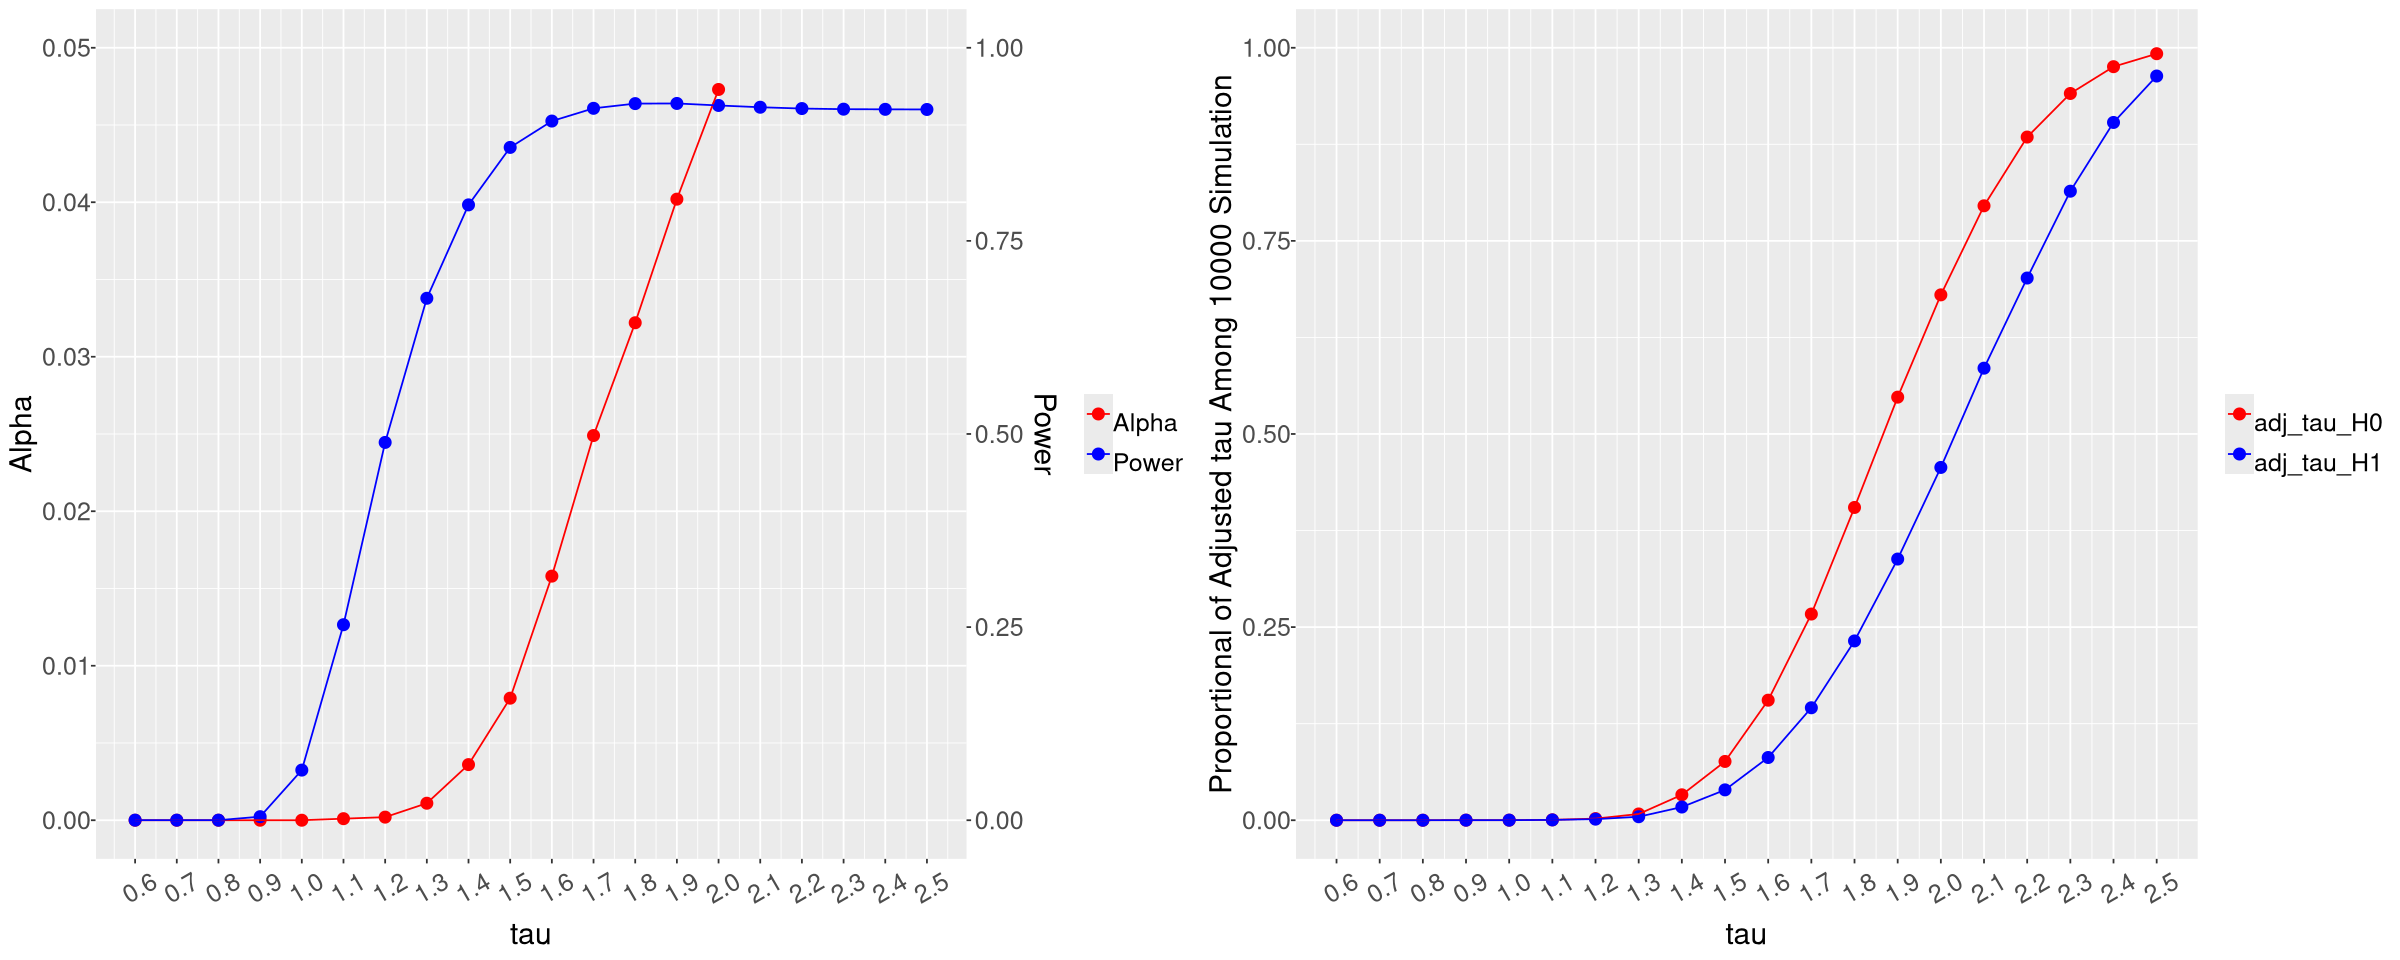

In [35]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_grid(plot_tau_ab, plot_tau_adj, align = "h", ncol = 2)

### The proportion of $\tau$ adjustment across different $\tau$ among 10000 simulations
### The $\tau$ here is preset for RMST test. If the proportion is too large, it means that most of the 'real' $\tau = max(RMST_E)$ 
### *The proportion increase sharpely after $\tau$ = 1.4, which means that the tail(right) of survival time in experiment group is more than 1.4. *
### *And the power of this test also increase significantly in this region. We need enough follow up time to guarantee the test power.*

## Compare our method when $\tau = 1.4$ with one sided log rank test

In [36]:
sim_size <- 10000  #simulate 10000 pairs of (E,C) under H0 and H1 respectively
acc_time <- 1.67
cen_time <- 1
tau <- 1.4
n1 <- 51
count_rmst <- 0

set.seed(2024)
start_time <- Sys.time() 
# Under H1
data_C <- expo_gen(N = n1 * sim_size,acc_time = acc_time, lambda = 1.609, cen_time = cen_time, arm = 0)
data_E <- expo_gen(N = n1 * sim_size,acc_time = acc_time, lambda = 0.916, cen_time = cen_time, arm = 1)
power_lr <- log_rank_sim(data_C = data_C, data_E = data_E,sim_size = sim_size,n = n1,alpha = 0.1, sided = 'greater') #function 4
rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E, data_C = data_C,tau = tau,sim_size = sim_size) 
count_rmst_rej <- foreach(k = 1:sim_size, .combine = '+') %dopar% {
        if (rmst_h1[2,k] - rmst_h1[1,k] > 0 & rmst_h1[2,k] > 0.74) # most powerful m1,n1
            {count_rmst <- 1}
        else
            {count_rmst <- 0}
        count_rmst
      }

end_time <- Sys.time()
cat(end_time - start_time)


9.561525

In [37]:
cat('Power of log rank test =', power_lr, '. Power of our method =' ,count_rmst_rej/sim_size)

Power of log rank test = 0.9137 . Power of our method = 0.7584

--------